<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w4_shap_class_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP: Regression Examples, and Interactions

## Import Packages and Set Up Environment

In [ ]:
# latest version of scikit-learn: might need a kernel restart
!pip install --upgrade scikit-learn==1.4.0 -q

In [ ]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
# SHAP is not normally part of a standard Python distribution
# I am installing it here by asking the underlying operating system to
# `pip install` the package (`-q` for a quiet output)
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.0 MB/s eta 0:00:00


## Regression, Wine Quality Example

* Based on the book "Molnar, Christoph. Interpreting Machine Learning Models With SHAP. https://christophmolnar.com/books/shap/. 2020."

### Data Loading and Inspection

In [ ]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017_2223/main/datasets/housing.csv'

In [ ]:
housing = pd.read_csv(url)

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


### Preparation for Training and Evaluation

In [ ]:
y = wine['quality']
X = wine.drop('quality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0, stratify=y
)

### A Sanity Check of SHAP with a Simple Linear Regression Model

#### Fitting and Scoring

In [ ]:
model = LinearRegression()
model = model.fit(X_train, y_train)

In [ ]:
eval_results = cross_validate(
    model, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
print(-eval_results['test_score'].mean(), eval_results['test_score'].std())
print(-eval_results['train_score'].mean(), eval_results['train_score'].std())

0.5937976390149533 0.033266394463595354
0.5825614837883729 0.008222901541250644


#### Inspecting (with SHAP)

In [ ]:
coefs = pd.DataFrame({
  'feature': X.columns,
  'coefficient': np.round(model.coef_, 3)
})
coefs

,feature,coefficient
0,fixed acidity,0.073
1,volatile acidity,-1.915
2,citric acid,-0.092
3,residual sugar,0.080
4,chlorides,-0.425
5,free sulfur dioxide,0.004
6,total sulfur dioxide,-0.001
7,density,-141.532
8,pH,0.627
9,sulphates,0.696


In [ ]:
explainer = shap.LinearExplainer(model, X_train)

In [ ]:
shap_values = explainer(X_test)

In [ ]:
# these are the SHAP values themselves that we can always use as a dataset
shap_values.values

array([[-0.01790395,  0.08922076, -0.00398967, ...,  0.02665368,
        -0.06419981,  0.06206327],
       [-0.01790395,  0.0317825 ,  0.00338154, ..., -0.04860378,
         0.04024674,  0.3971852 ],
       [-0.0543682 , -0.02565576,  0.00246014, ...,  0.07055387,
        -0.0363474 ,  0.06206327],
       ...,
       [-0.00331825,  0.07007468, -0.00214687, ..., -0.10504688,
         0.03328363, -0.31248477],
       [ 0.09148881, -0.14053227, -0.00214687, ..., -0.01097505,
         0.03328363, -0.03650201],
       [ 0.0185603 , -0.04480184, -0.01412508, ...,  0.12699697,
         0.06113605,  0.27890687]])

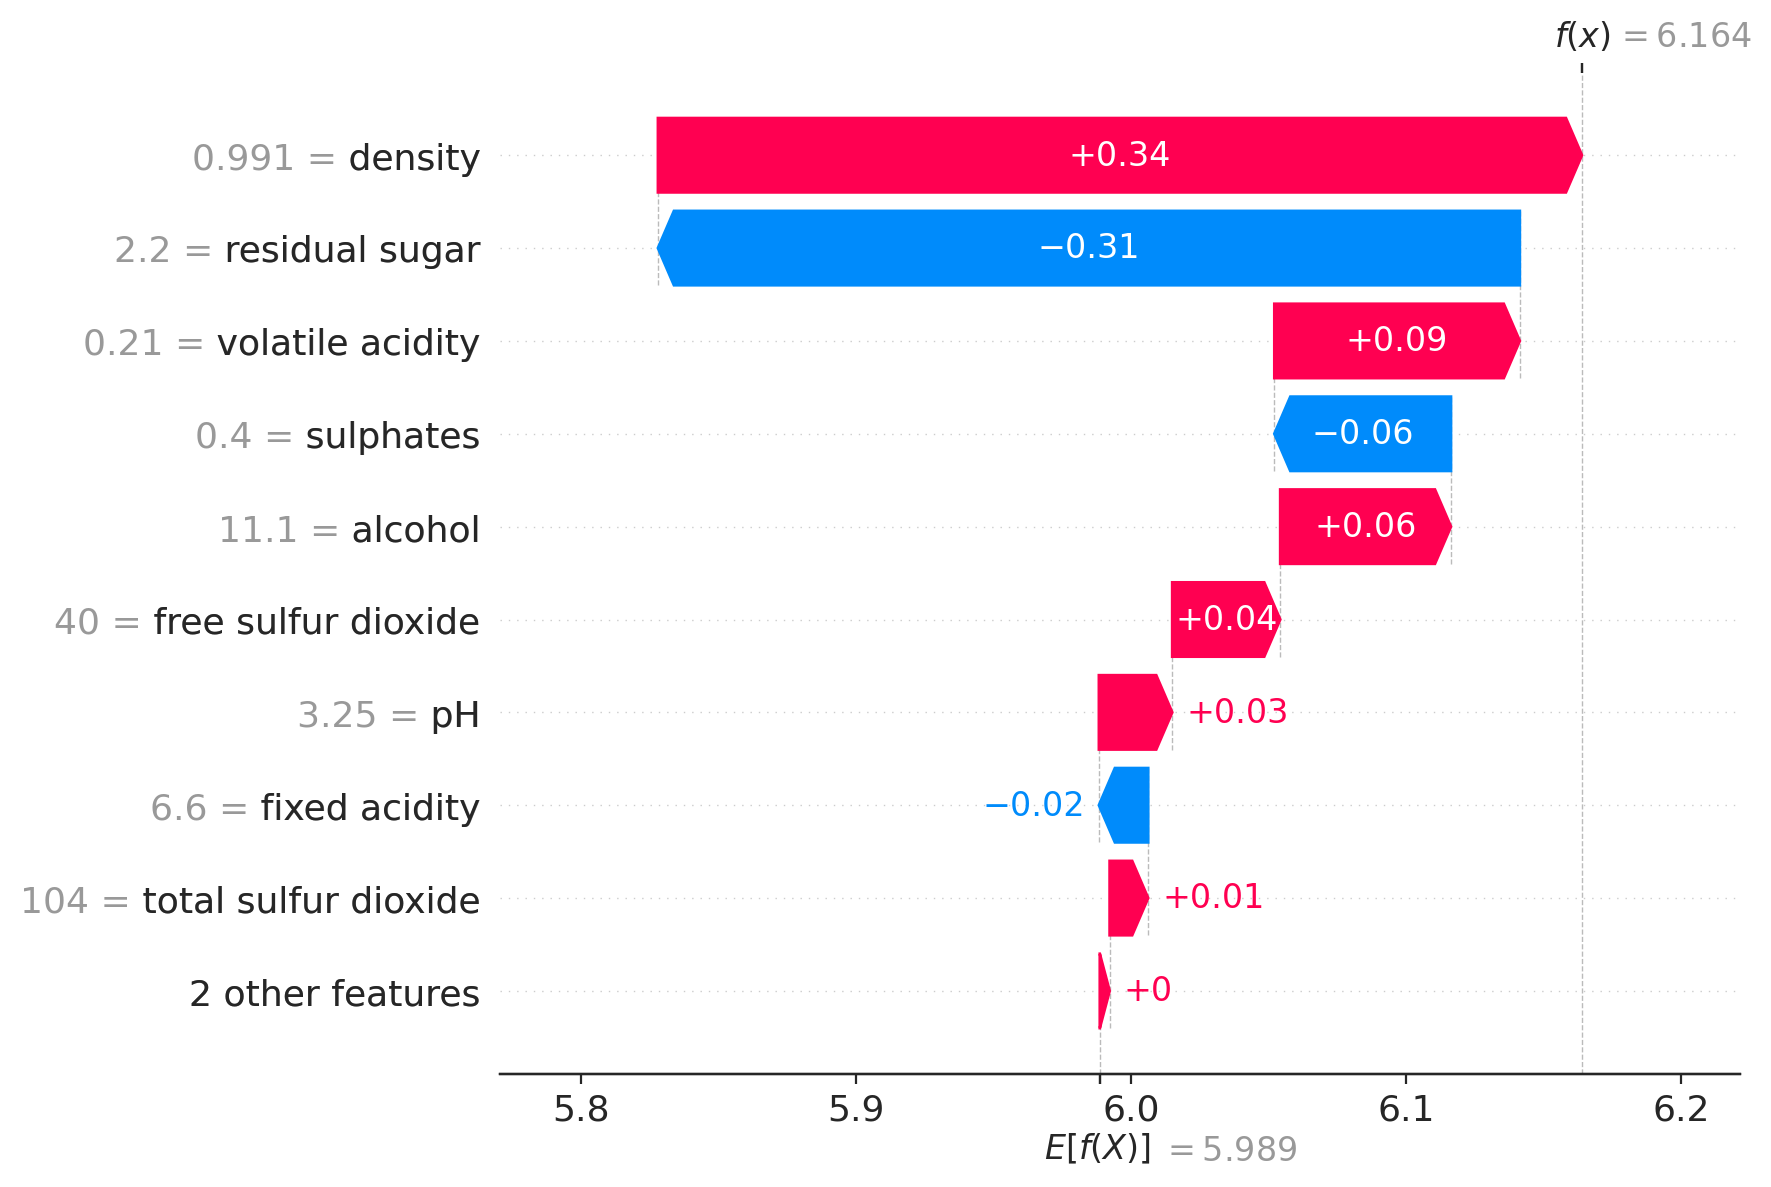

In [ ]:
# for a random instance
shap.plots.waterfall(shap_values[0])

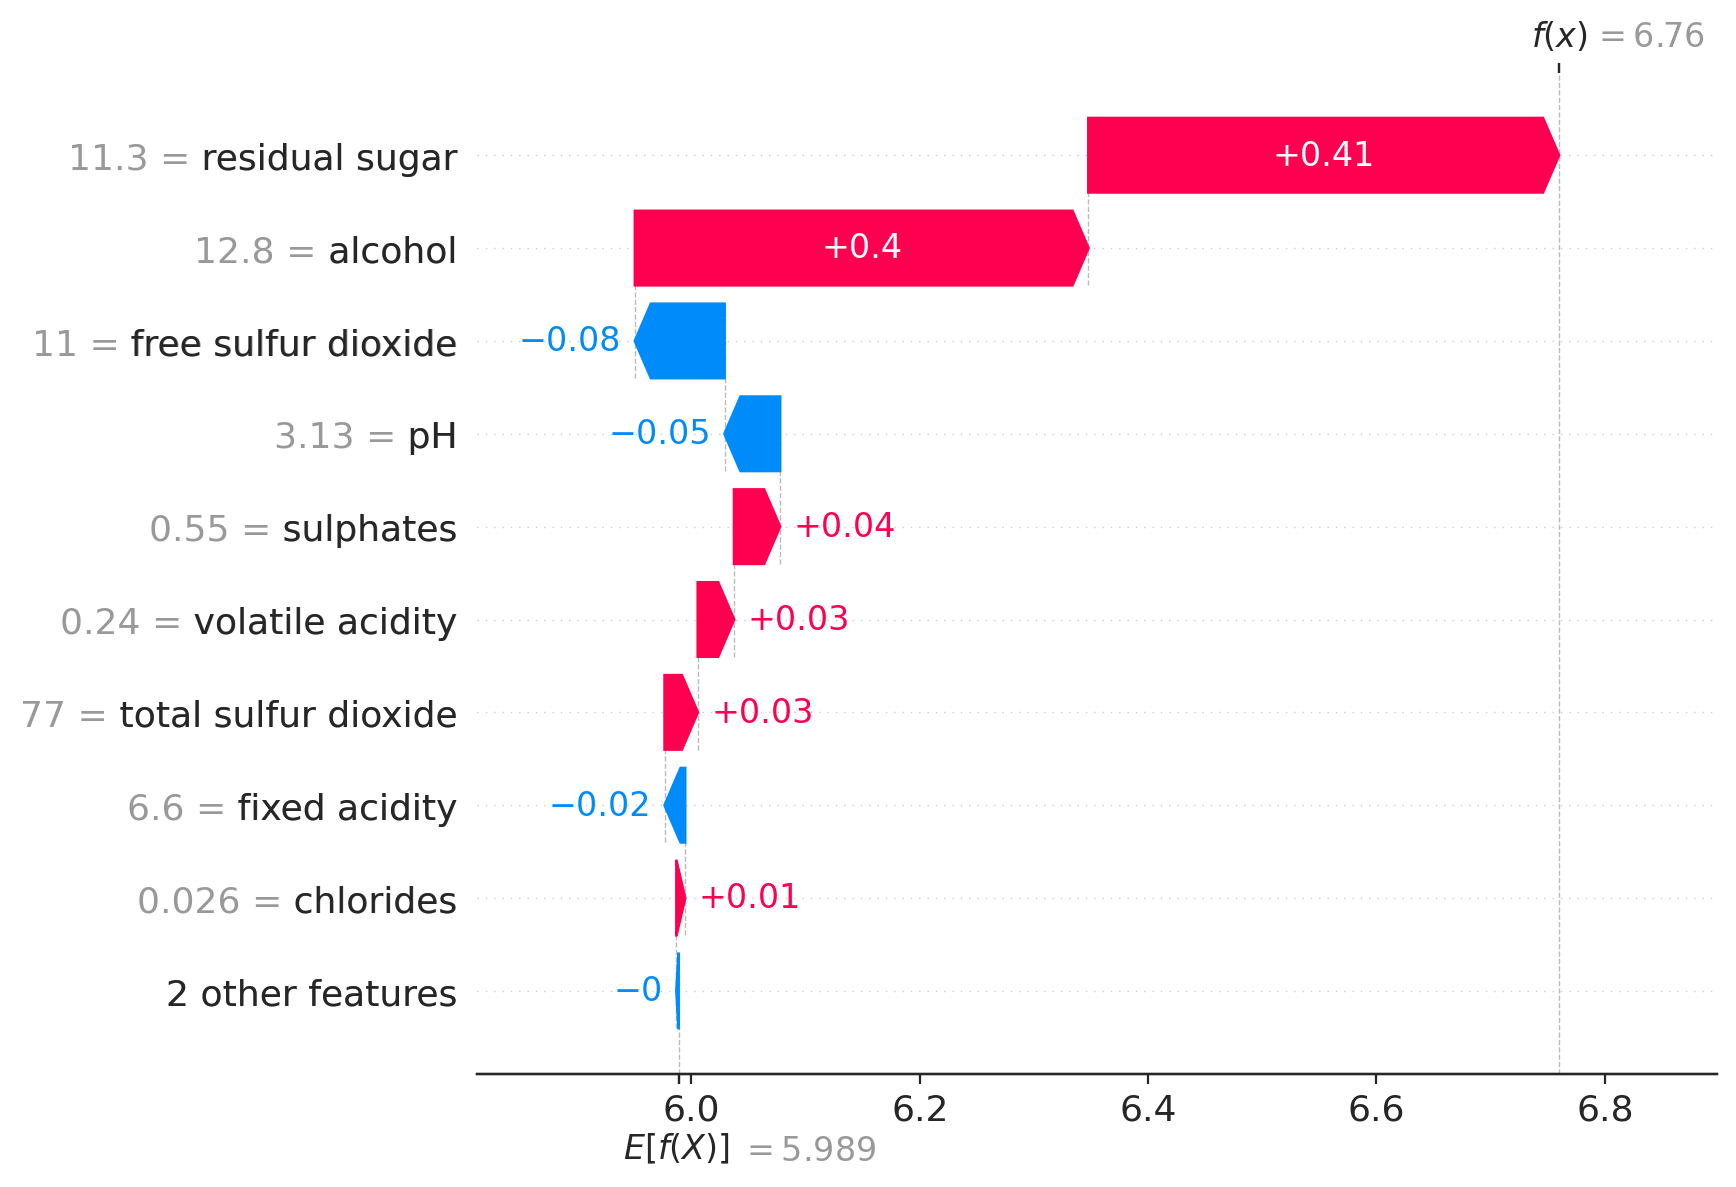

In [ ]:
# another wine
shap.waterfall_plot(shap_values[1])

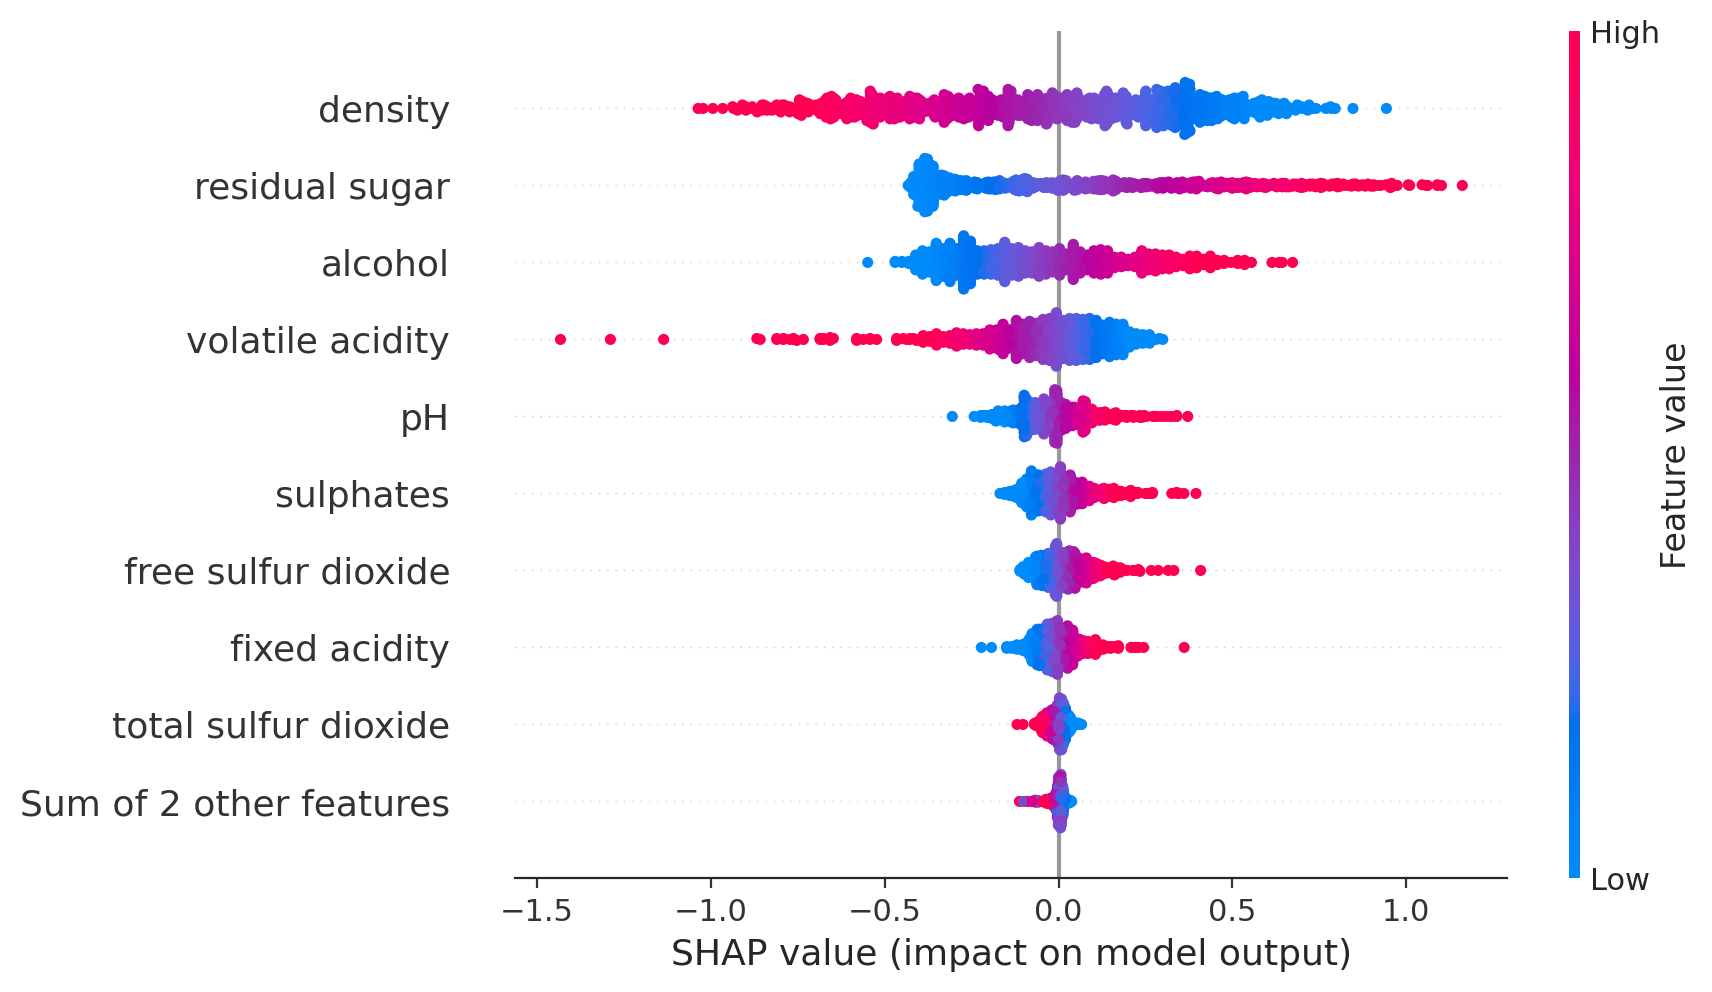

In [ ]:
# global model
shap.plots.beeswarm(shap_values)

In [ ]:
# what does the above tell you what the average effect of features in the predictions?
# how does it reflect the coefficients assigned to each feature by the model?

#### SHAP Scatter Plots

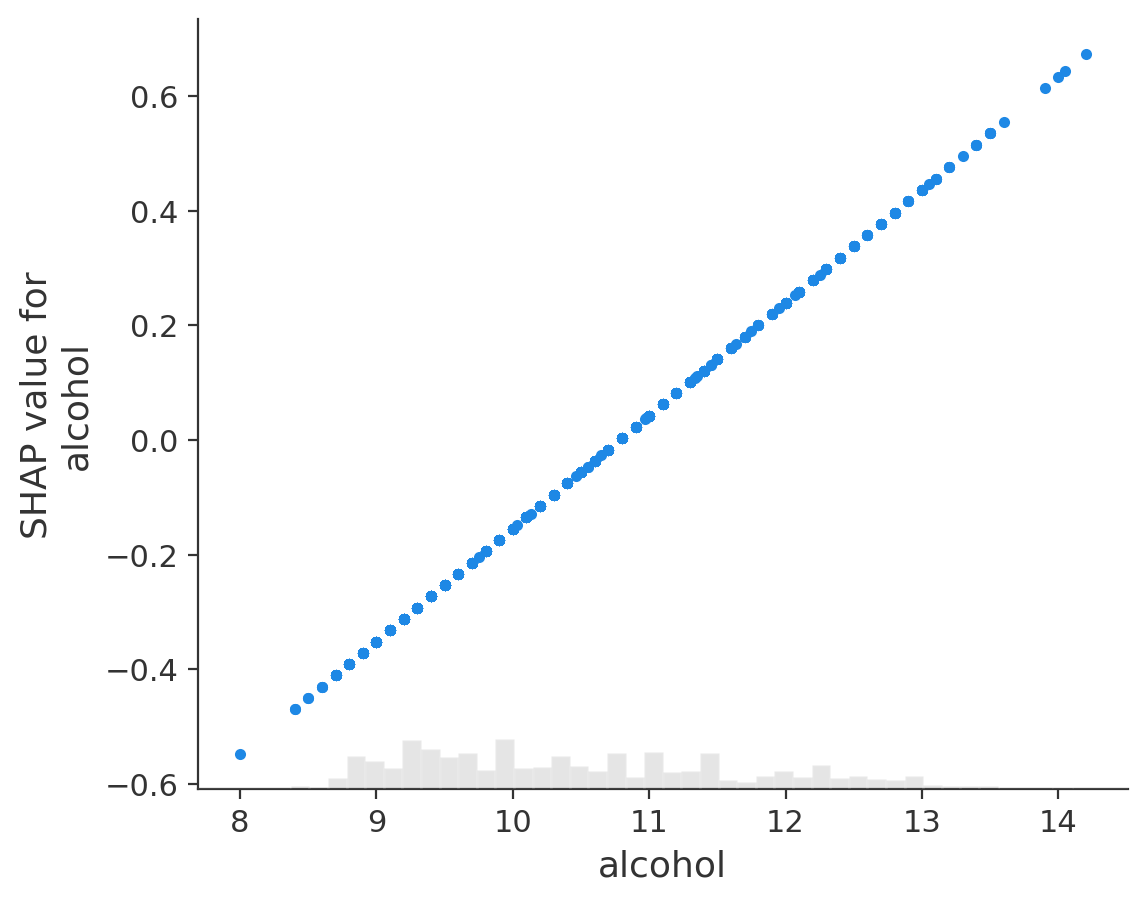

In [ ]:
shap.plots.scatter(shap_values[:, 'alcohol'])

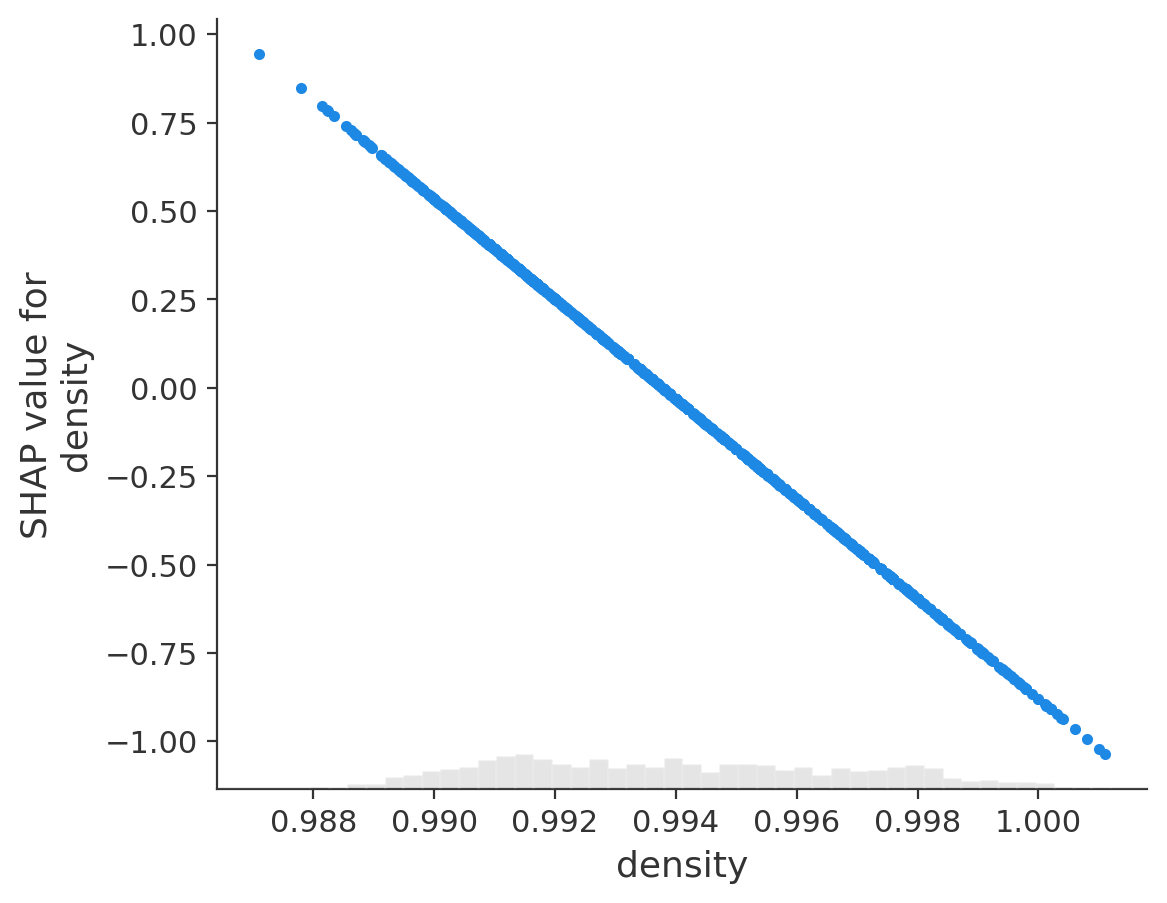

In [ ]:
shap.plots.scatter(shap_values[:, 'density'])

### A Random Forest Regressor Now

#### Fitting and Cross-Validating

In [ ]:
model = RandomForestRegressor(
    max_depth=8, min_samples_split=30, min_samples_leaf=30, n_estimators=400
)
model = model.fit(X_train, y_train)

In [ ]:
eval_results = cross_validate(
    model, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
print(-eval_results['test_score'].mean(), eval_results['test_score'].std())
print(-eval_results['train_score'].mean(), eval_results['train_score'].std())

0.5785662261894913 0.035821814019792036
0.5015170339691363 0.010238048786407125


#### Inspecting with SHAP

In [ ]:
explainer = shap.TreeExplainer(model, X_train)
explainer

In [ ]:
shap_values = explainer(X_test)

 97%|=================== | 949/980 [00:33<00:01]       

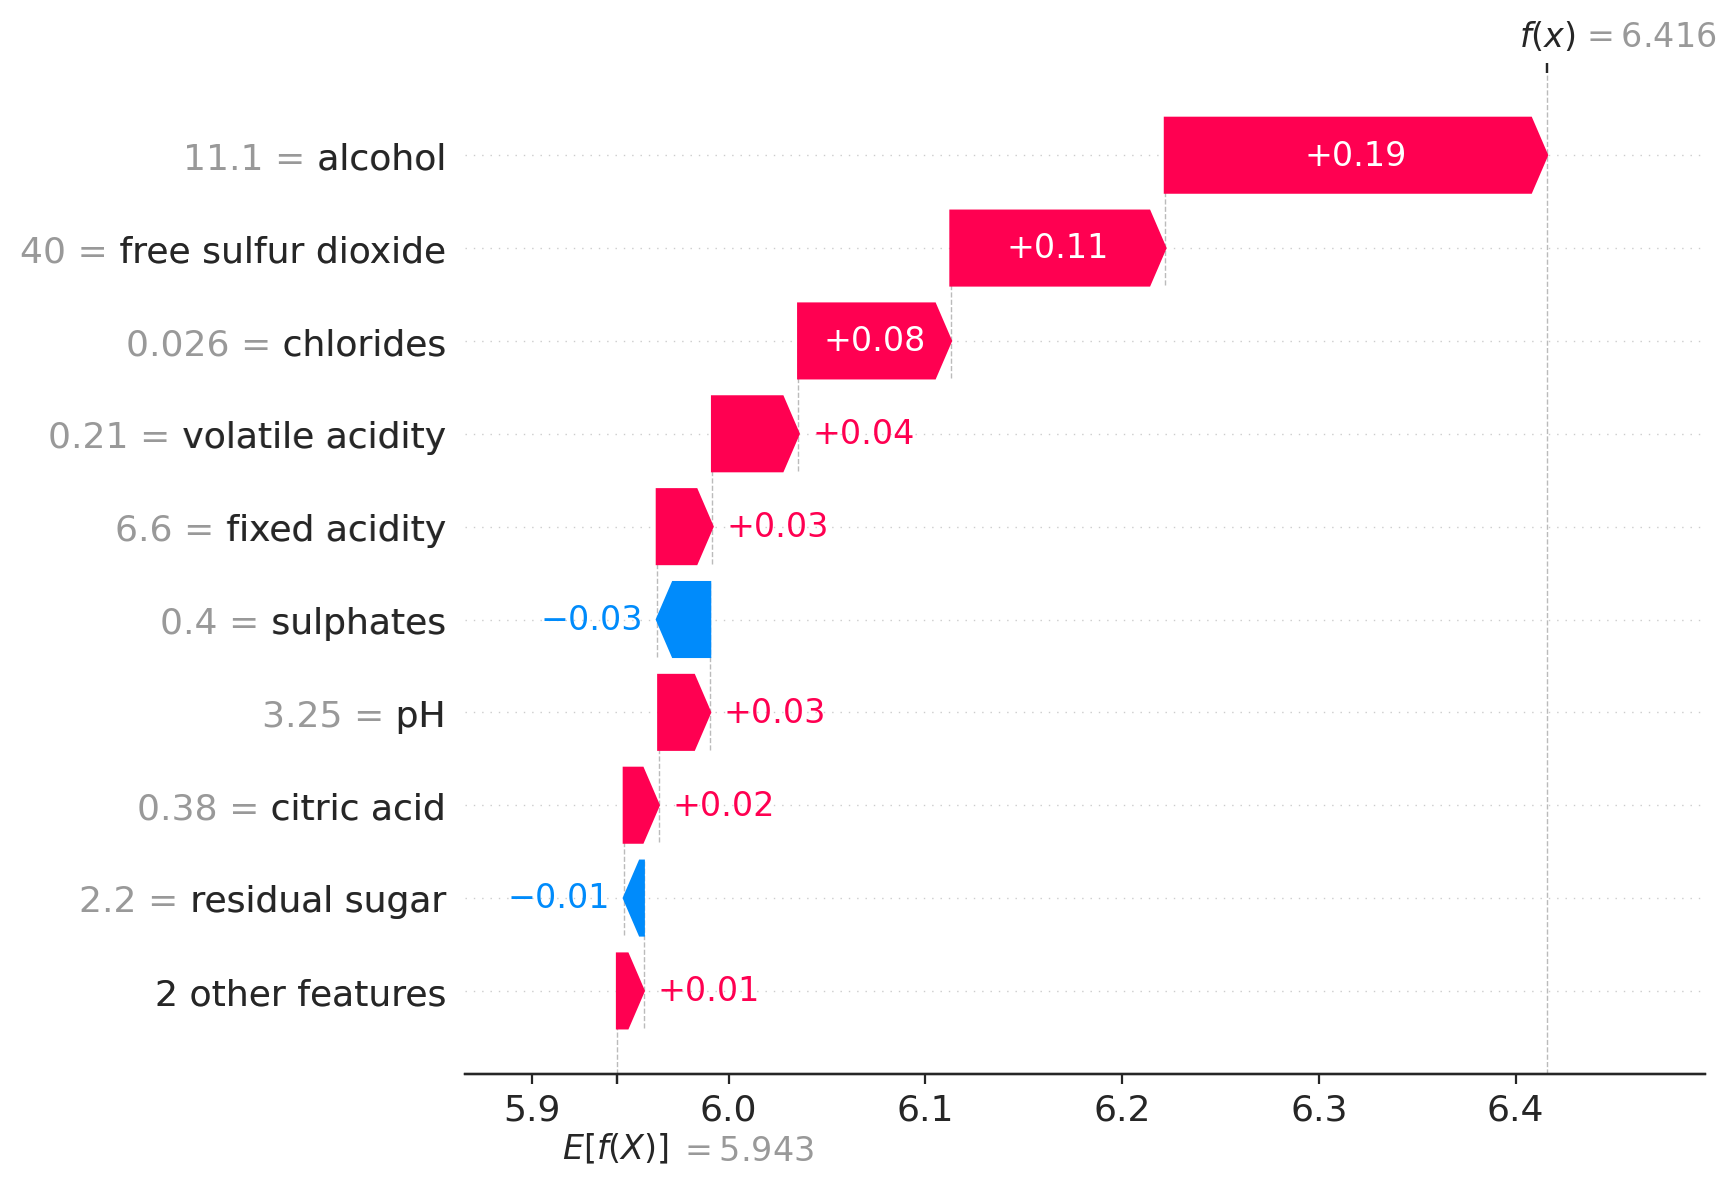

In [ ]:
# for a random instance
shap.plots.waterfall(shap_values[0])

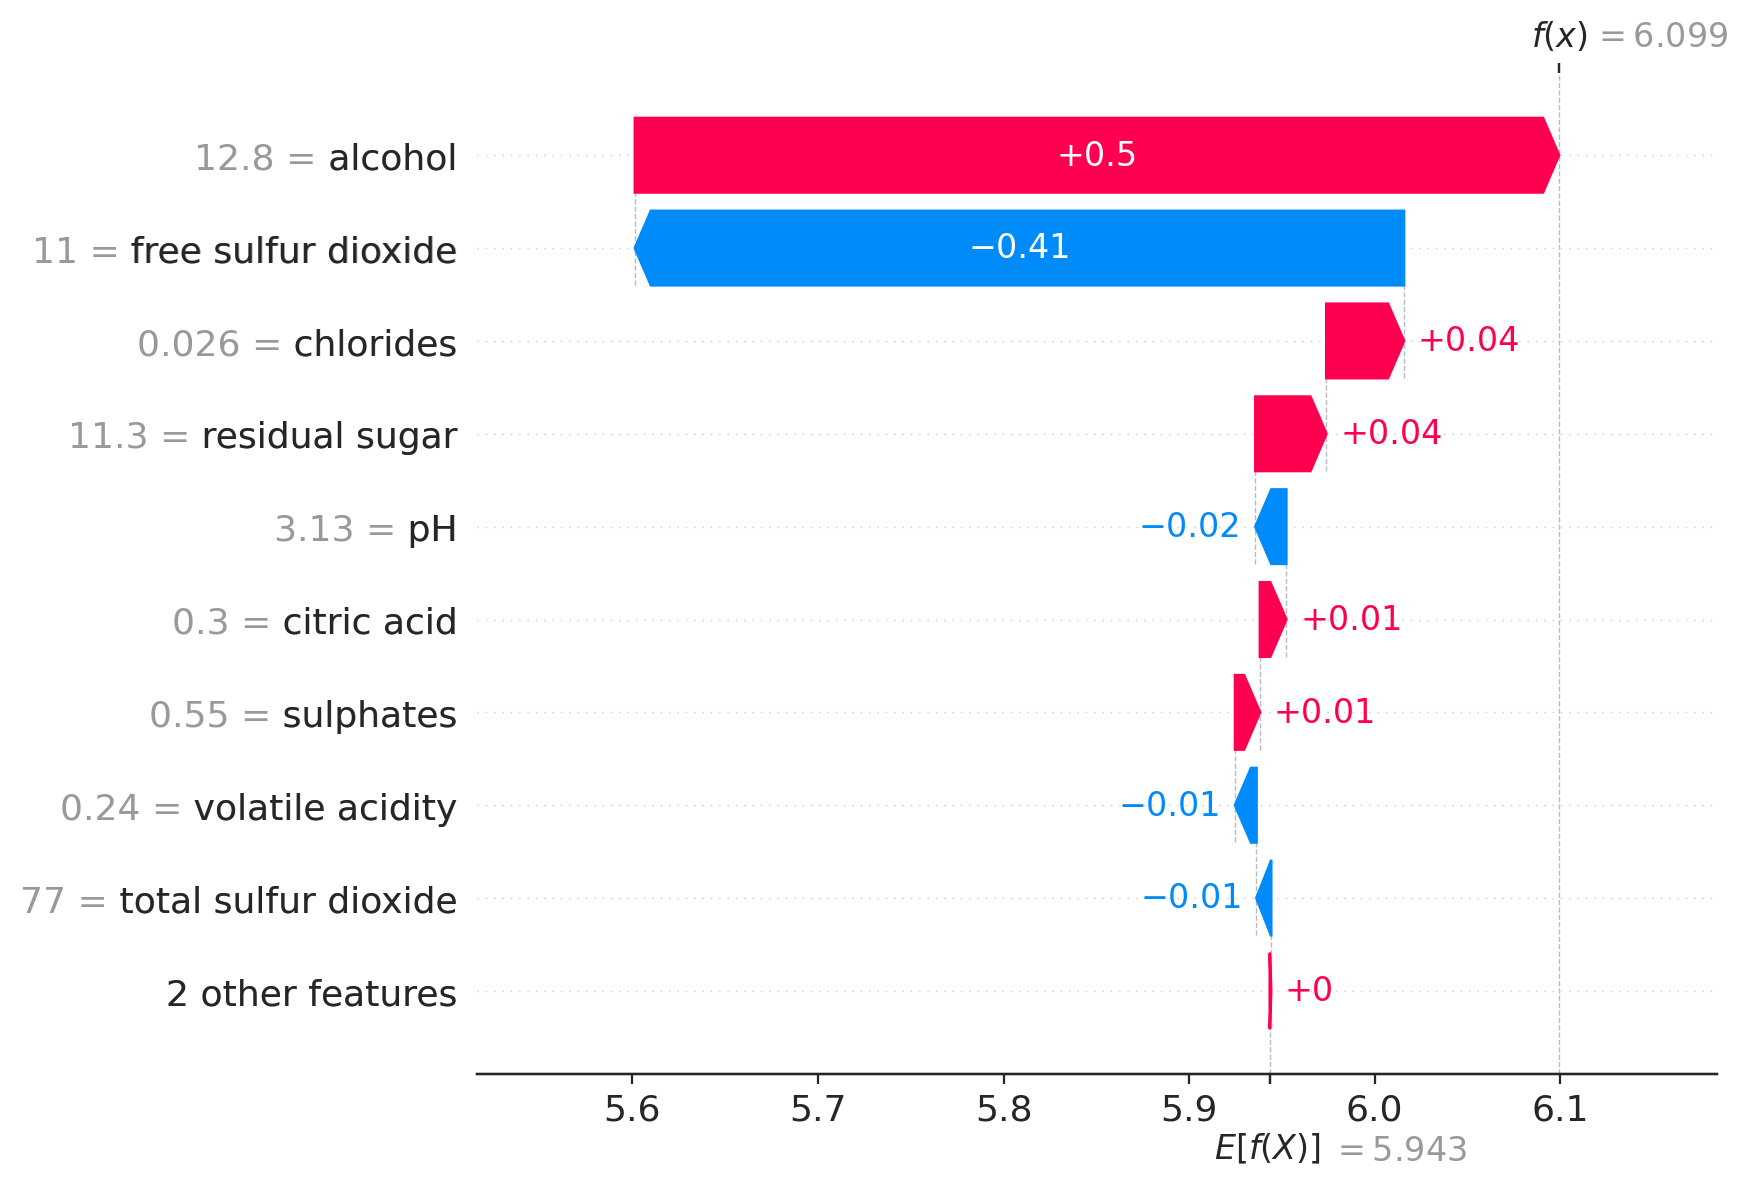

In [ ]:
# another wine
shap.waterfall_plot(shap_values[1])

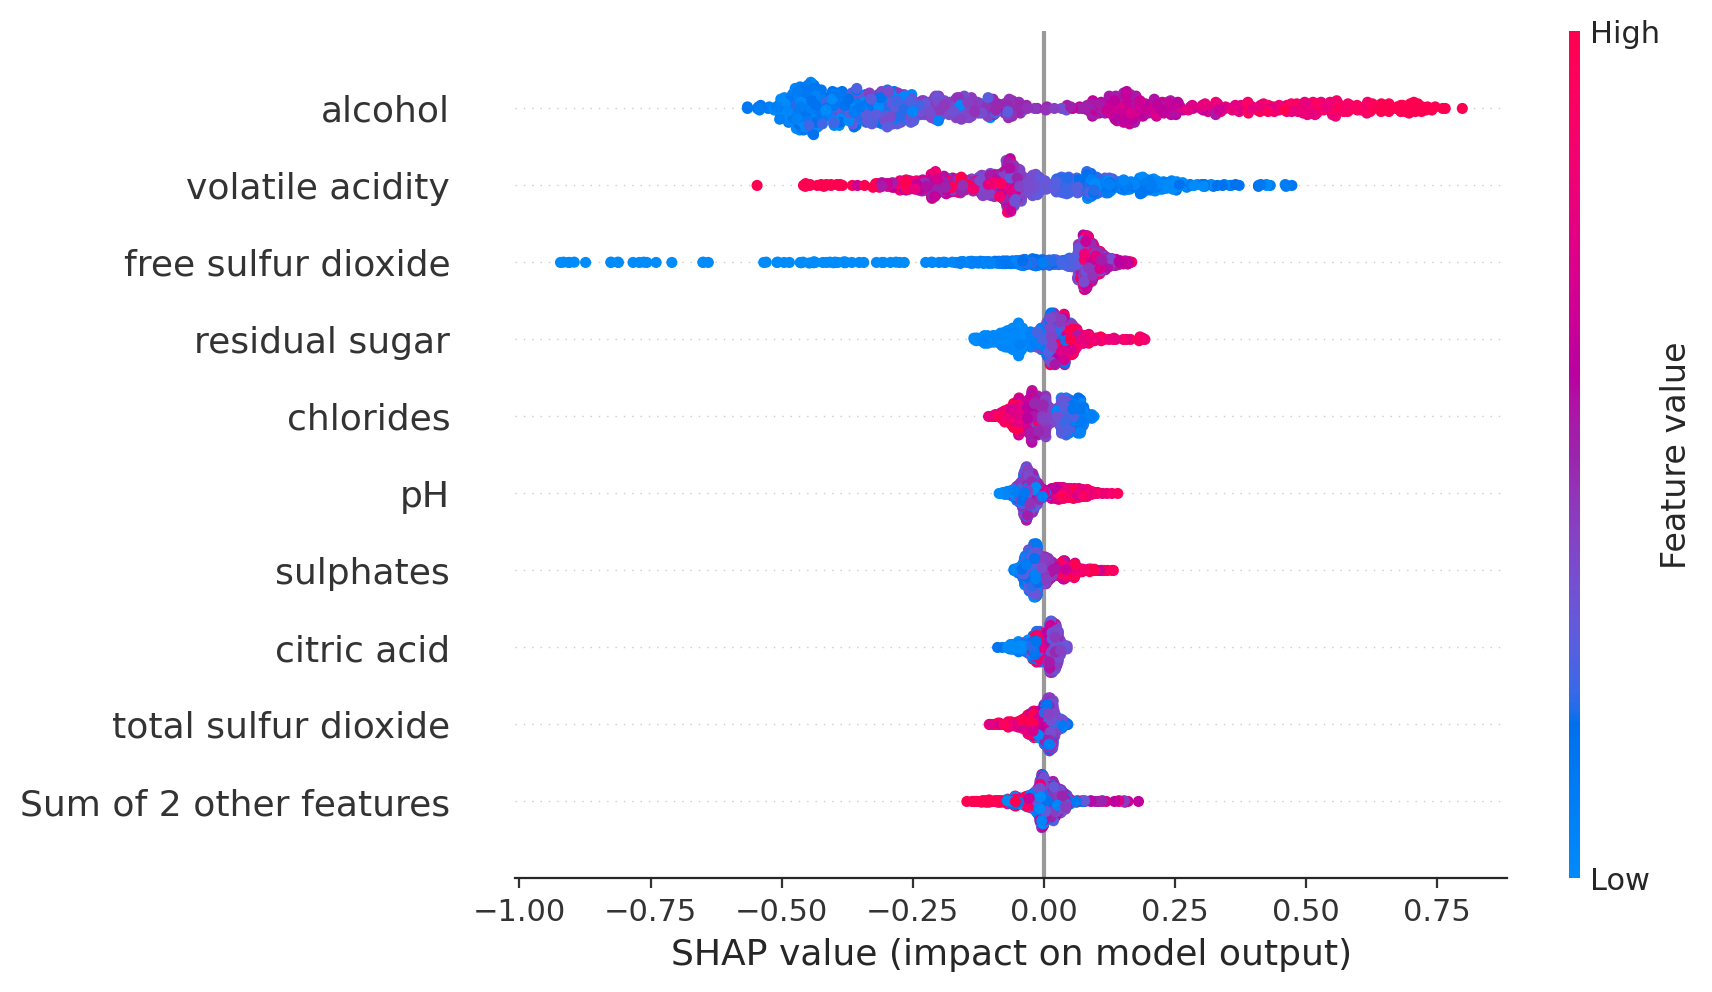

In [ ]:
# global model
shap.plots.beeswarm(shap_values)

#### SHAP Scatter Plots

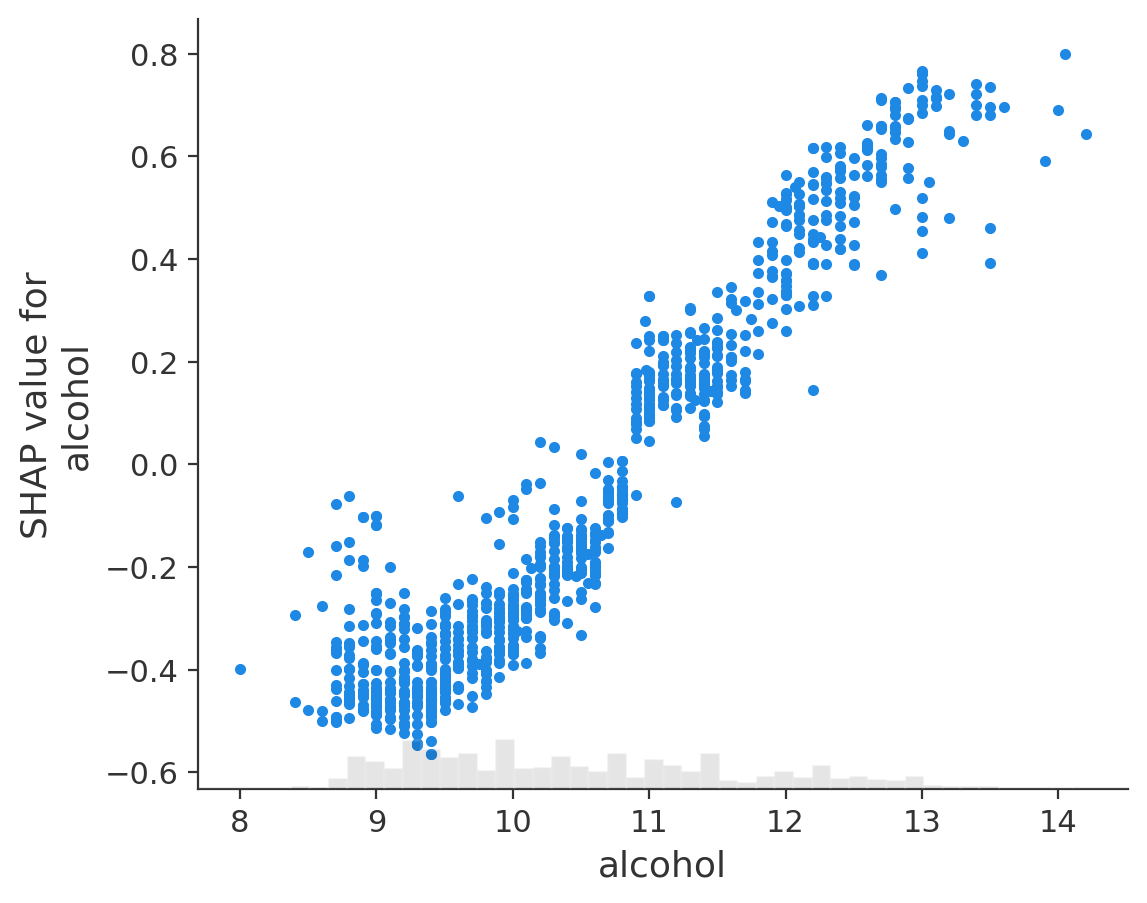

In [ ]:
shap.plots.scatter(shap_values[:, 'alcohol'])

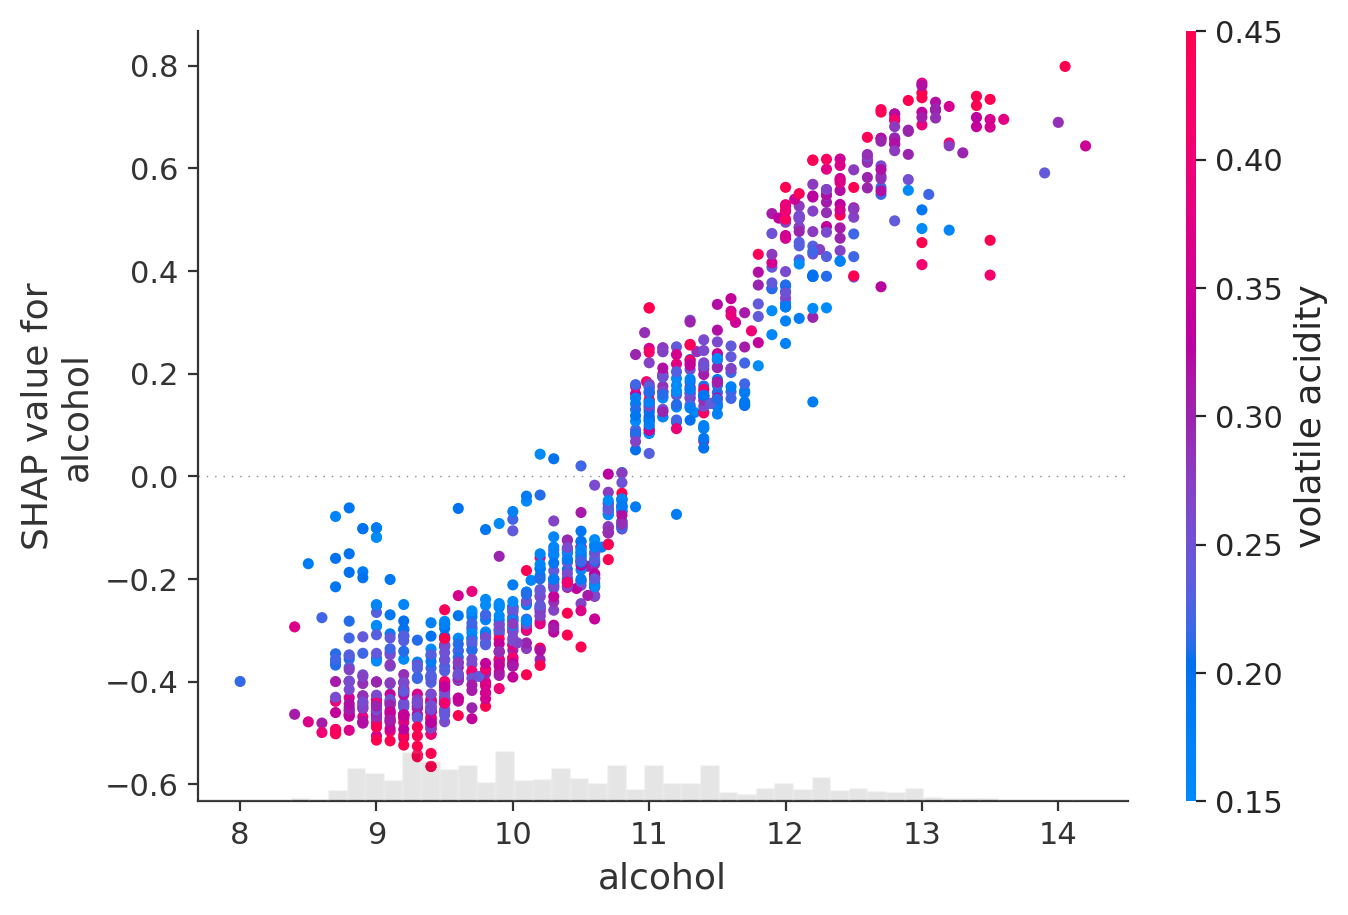

In [ ]:
shap.plots.scatter(shap_values[:,"alcohol"], color=shap_values)

* "Generally, a higher alcohol level corresponds to a higher SHAP value.

* "Examining cases with low volatile acidity reveals an interesting interaction with wines that have a low alcohol level.
    - For wines with low alcohol (between 8% and 11%), if the wines have low volatile acidity, then the SHAP value for alcohol is higher compared to wines with similar alcohol levels.

    - The relationship reverses for wines with higher alcohol levels: a higher volatile acidity level is associated with slightly higher SHAP values for alcohol."

* "We could infer that volatile acidity alters the effect of alcohol on the predicted wine quality."